In [73]:
import glob
from stress_addition_model import (
    sam_prediction,
    Predicted_LCs,
    get_sam_lcs,
    SAM_Setting,
)
from helpers import compute_lc, find_lc_99_max, compute_lc_from_curve
from plotting import plot_sam_prediction
from data_formats import ExperimentData, read_data
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from dataclasses import dataclass
from tqdm import tqdm
import time
from scipy.optimize import minimize
import numpy as np
from dose_reponse_fit import ModelPredictions
import pickle
from glob import glob
import re
import matplotlib.lines as mlines
from stress_survival_conversion import survival_to_stress, stress_to_survival

In [74]:
get_float = lambda s: float(re.findall(r"[-+]?(?:\d*\.*\d+)", s)[0])

In [75]:
@dataclass
class Prediction:
    data: ExperimentData
    main_fit: ModelPredictions
    stressor_fit: ModelPredictions
    best_stress: float
    best_pred: np.ndarray[np.float32]
    stressor_name: str
    best_r2: float
    best_pred_r2: np.ndarray


betas = glob("betas/*.csv")

res = {}
for p in betas:
    res[get_float(p)] = pd.read_csv(p, index_col=0)

In [76]:
dropped = {}

for q, df in res.items():
    mask = np.logical_or(df.d_main <= df.d_stress, df.best == 0)
    dropped[q] = list(df.loc[mask].index)
    res[q] = df.loc[~mask]
dropped

{7.0: [0, 13, 19, 33, 34],
 3.7: [0, 13, 19, 33, 34],
 5.0: [0, 13, 19, 33, 34],
 2.6: [0, 13, 19, 33, 34],
 15.0: [0, 13, 19, 33, 34],
 2.5: [0, 13, 19, 33, 34],
 3.5: [0, 13, 19, 33, 34],
 8.0: [0, 13, 19, 33, 34],
 2.9: [0, 13, 19, 33, 34],
 2.4: [0, 13, 19, 33, 34],
 3.4: [0, 13, 19, 33, 34],
 2.8: [0, 13, 19, 33, 34],
 3.3: [0, 13, 19, 33, 34],
 6.0: [0, 13, 19, 33, 34],
 3.1: [0, 13, 19, 33, 34],
 4.5: [0, 13, 19, 33, 34],
 3.2: [0, 13, 19, 33, 34],
 2.7: [0, 13, 19, 33, 34],
 4.0: [0, 13, 19, 33, 34],
 3.0: [0, 13, 19, 33, 34],
 10.0: [0, 13, 19, 33, 34],
 20.0: [0, 13, 19, 33, 34],
 3.6: [0, 13, 19, 33, 34]}

In [77]:
losses = pd.Series({a: b.lowest_mse.mean() for a, b in res.items()}).sort_values()
losses

20.0    36.001248
15.0    36.261146
10.0    37.027065
8.0     37.605730
7.0     38.063835
6.0     38.620297
5.0     39.449271
4.5     40.015265
4.0     40.770854
3.7     41.352452
3.6     41.581617
3.5     41.824658
3.4     42.109758
3.3     42.403203
3.2     42.727669
3.1     43.090845
3.0     43.510383
2.9     43.964808
2.8     44.483851
2.7     45.056327
2.6     45.730927
2.5     46.472490
2.4     47.341677
dtype: float64

In [78]:
def regression_line(x, intercept):
    return x + intercept


def fit_intercept_only(x, y):
    # Objective function to minimize: sum of squared differences from the line with fixed slope 1
    def obj_fun(intercept):
        return np.sum((y - (x + intercept)) ** 2)

    result = minimize(obj_fun, x0=[0])  # Start from intercept 0
    return result.x[0]  # Return the optimized intercept


def plot(param, df):
    mask = df.d_main == 1
    padding = df.loc[mask].copy()
    padding.d_main = 0.995  # Adjust the main value slightly

    # Calculate predictions for the adjusted and original data
    padding_pred = survival_to_stress(
        padding.d_stress, q=param, p=param
    ) - survival_to_stress(padding.d_main, q=param, p=param)
    padding["pred"] = padding_pred

    original_pred = survival_to_stress(
        df.d_stress, p=param, q=param
    ) - survival_to_stress(df.d_main, p=param, q=param)
    df["pred"] = original_pred

    # Plot the data points
    plt.figure(figsize=(8, 8))
    plt.scatter(
        padding["pred"], padding["best"], color="blue", label="No Control Stress"
    )
    plt.scatter(
        df.loc[~mask, "pred"],
        df.loc[~mask, "best"],
        color="orange",
        label="Control Stress",
    )

    # Plot the identity line
    x = np.linspace(0, df["pred"].max(), 30)
    plt.plot(x, x, color="red", label="Identity Line")  # Identity line

    # Fit and plot the regression line
    combined_x = np.concatenate((padding["pred"], df.loc[~mask, "pred"]))
    combined_y = np.concatenate((padding["best"], df.loc[~mask, "best"]))
    intercept = fit_intercept_only(combined_x, combined_y)
    plt.plot(
        x,
        regression_line(x, intercept),
        color="green",
        linestyle="--",
        label="Fitted Line",
    )

    plt.legend()
    plt.title(
        f"Regression Analysis for q=p={param:.2f} intercept = {float(intercept) :.2f}"
    )
    plt.xlabel("Predicted Stress")
    plt.ylabel("Optim Stress")
    plt.show()

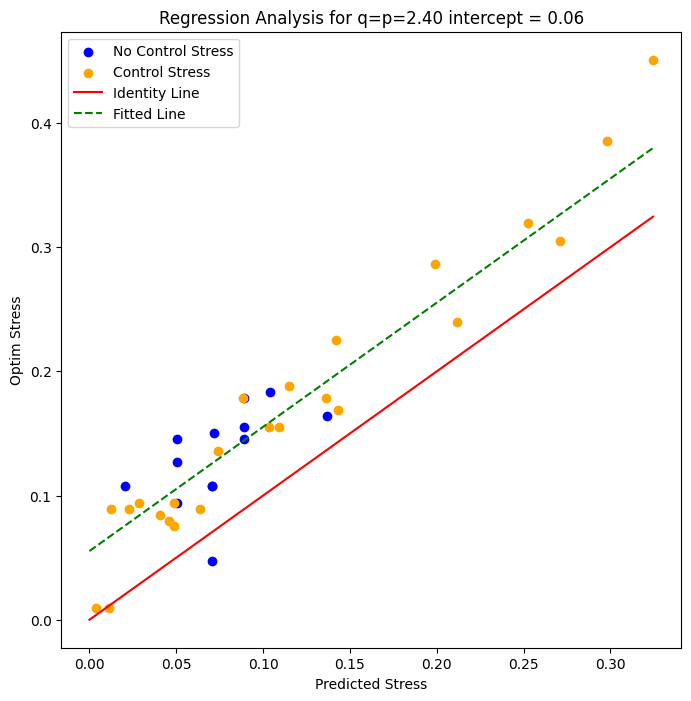

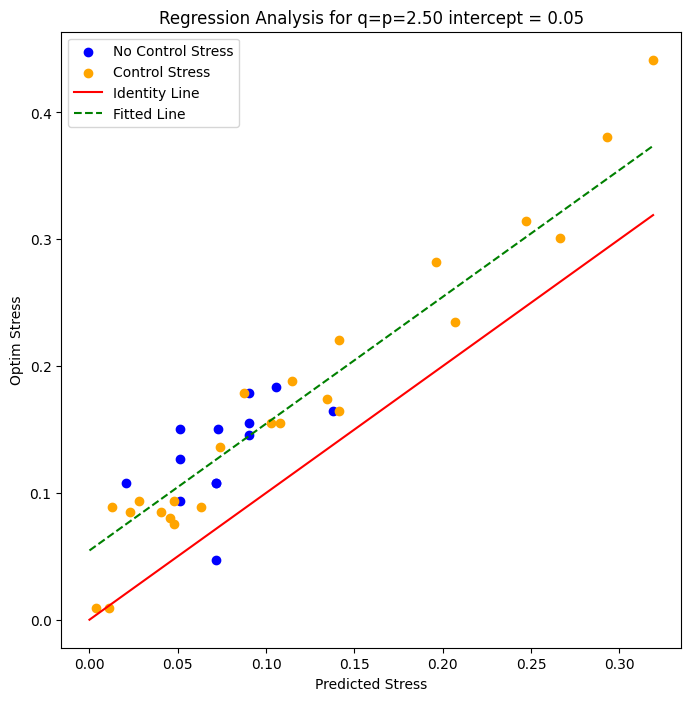

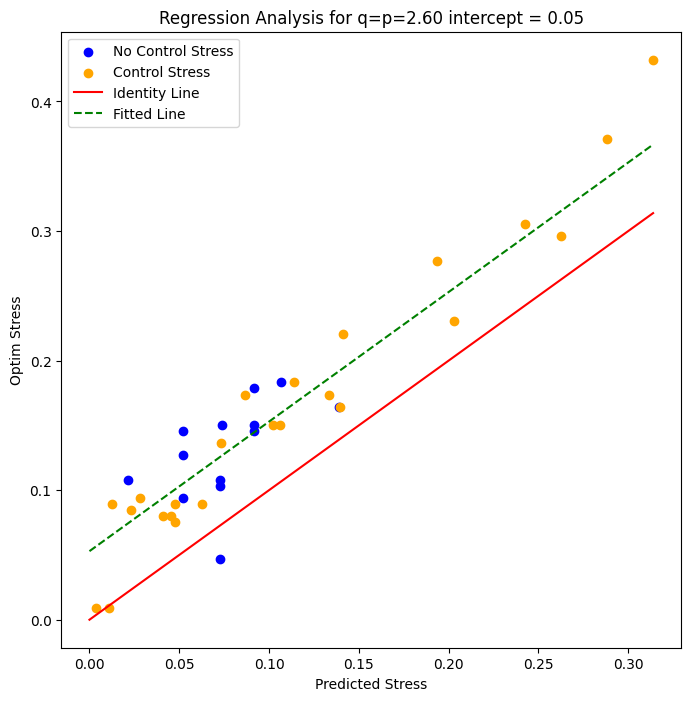

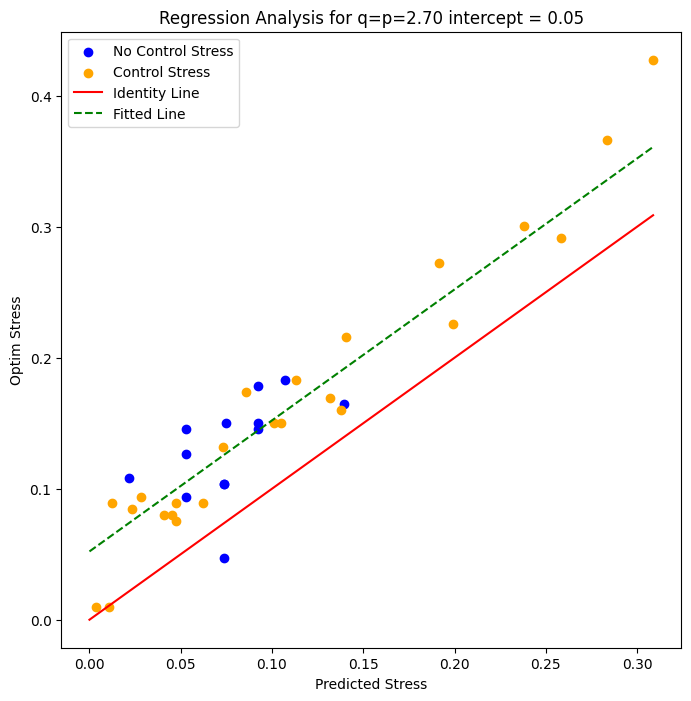

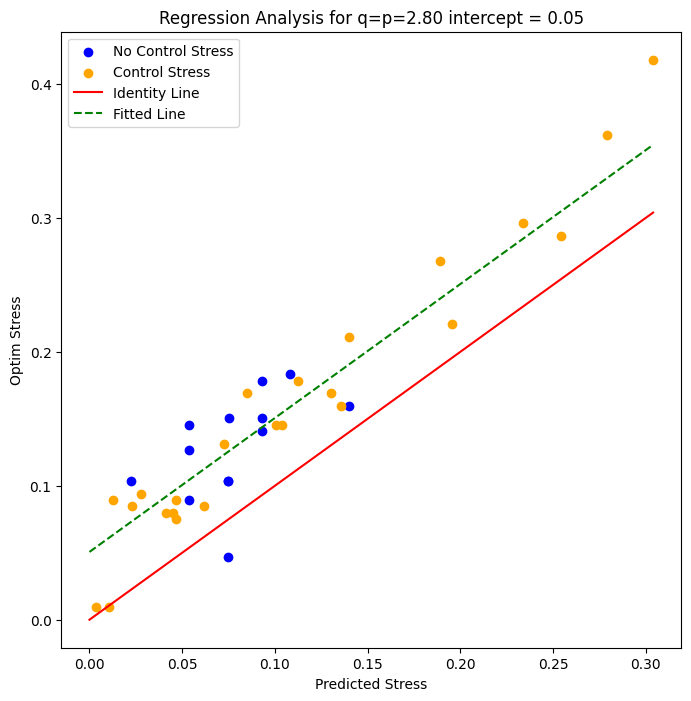

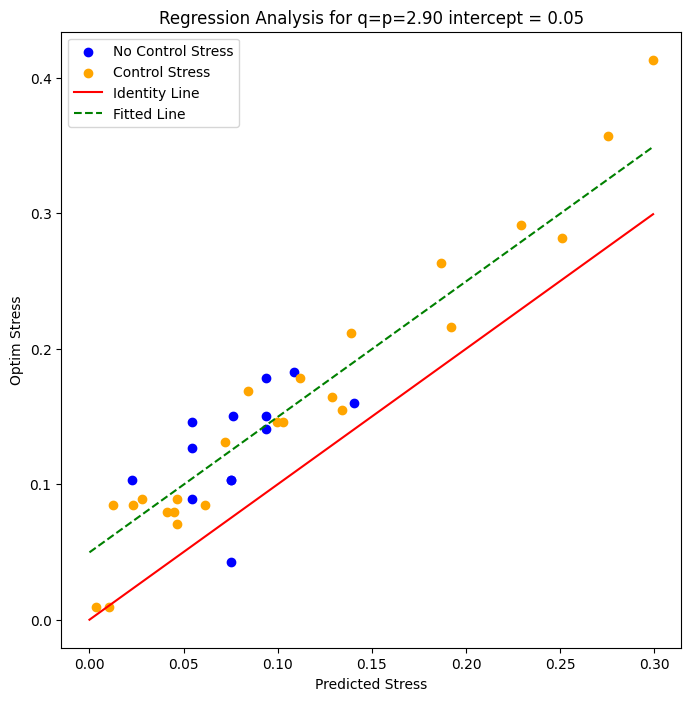

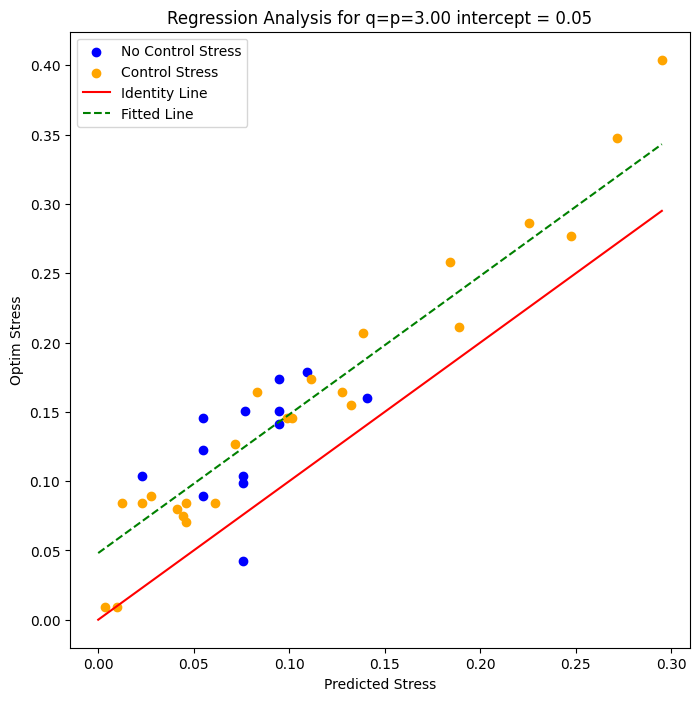

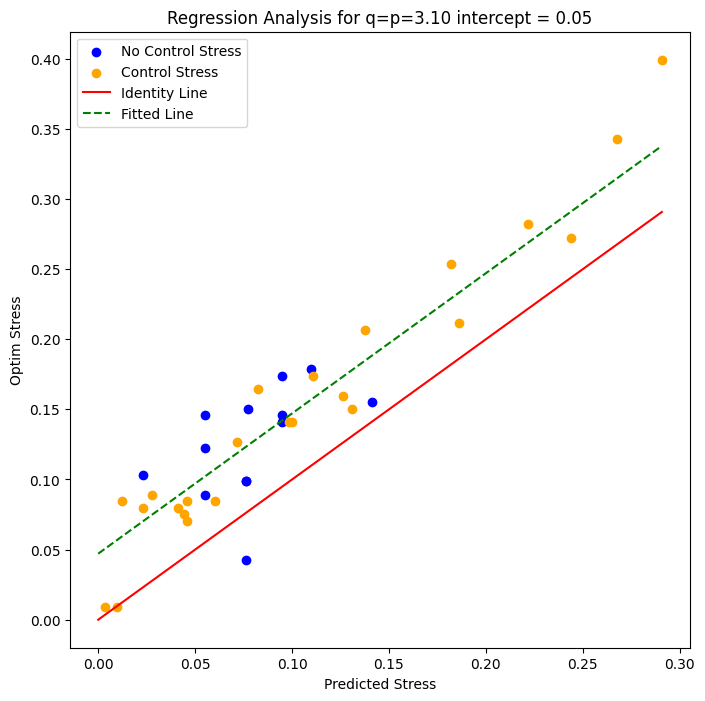

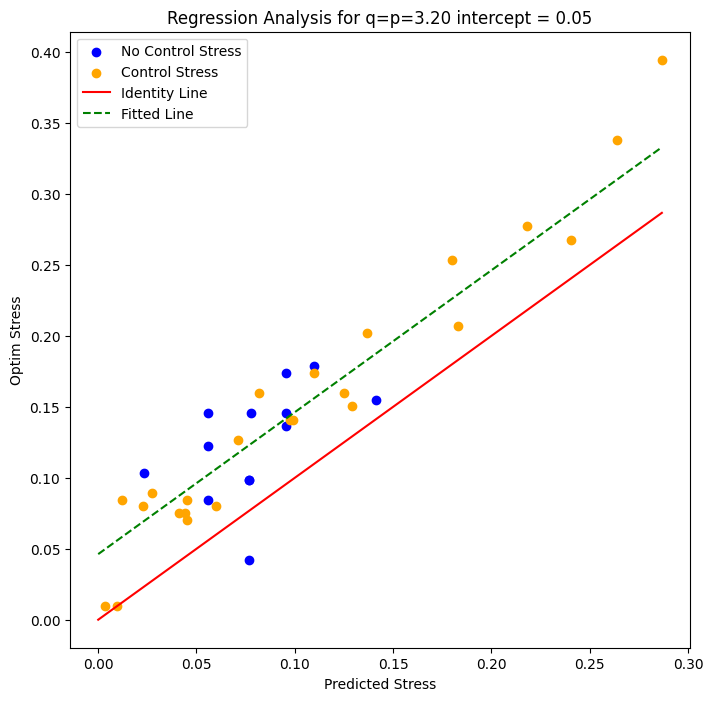

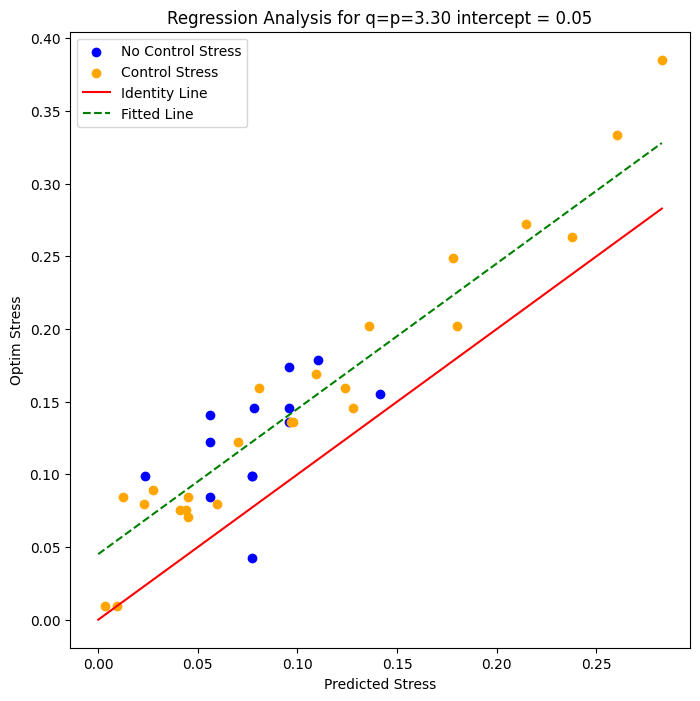

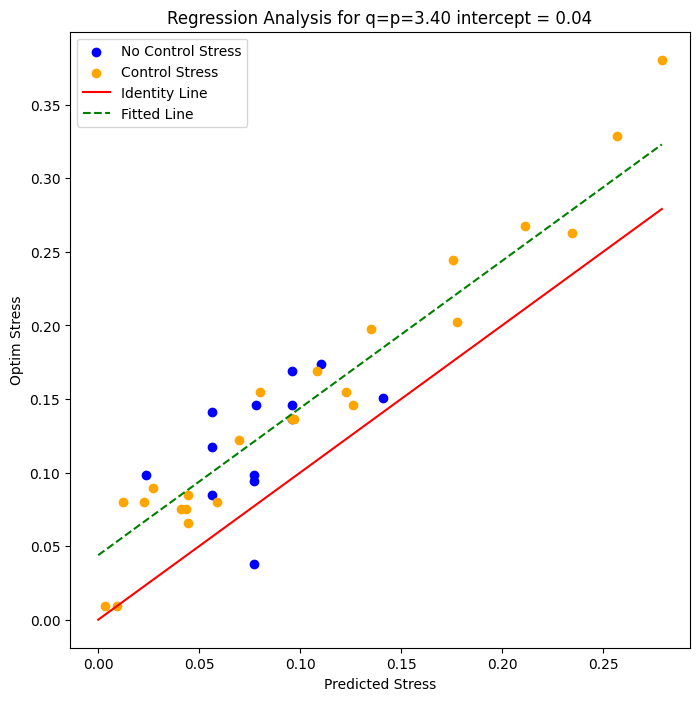

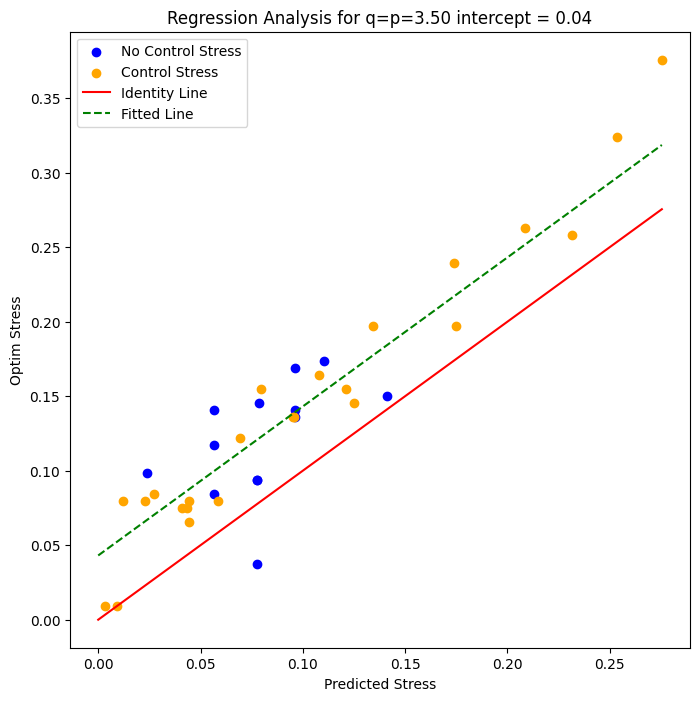

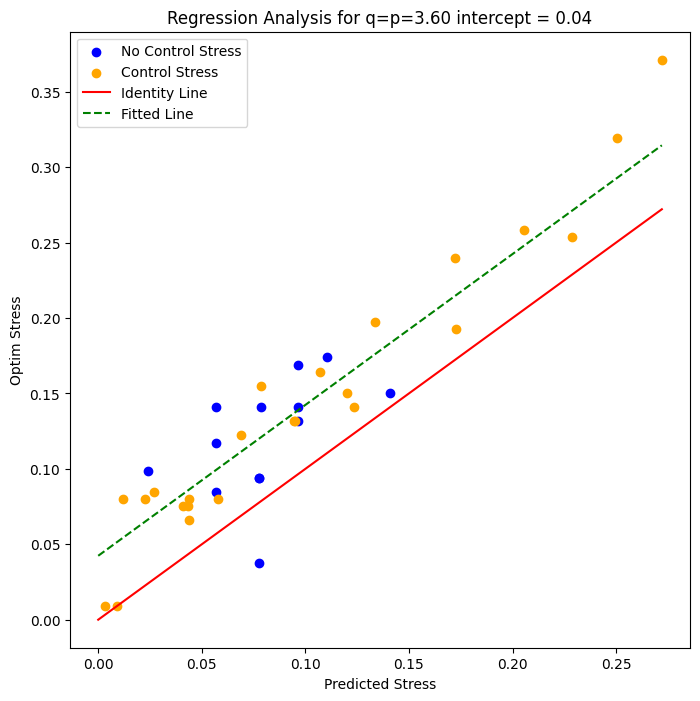

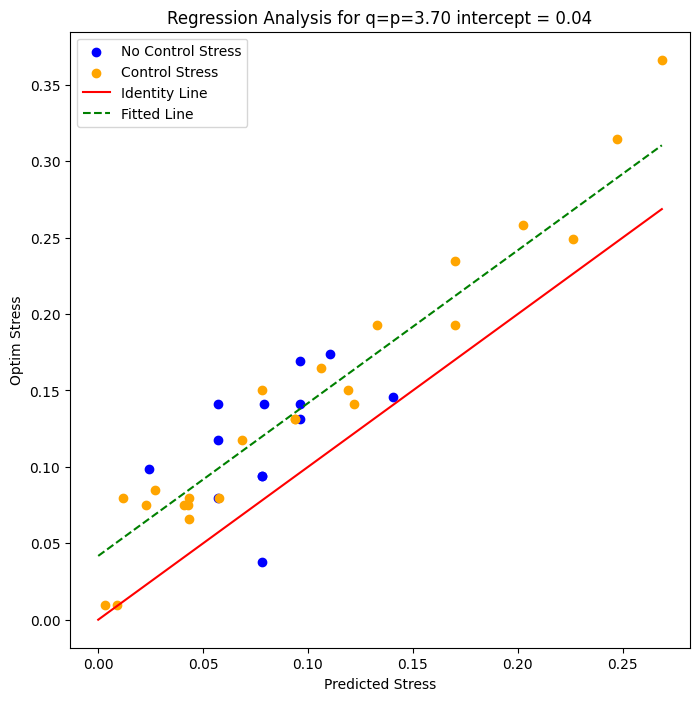

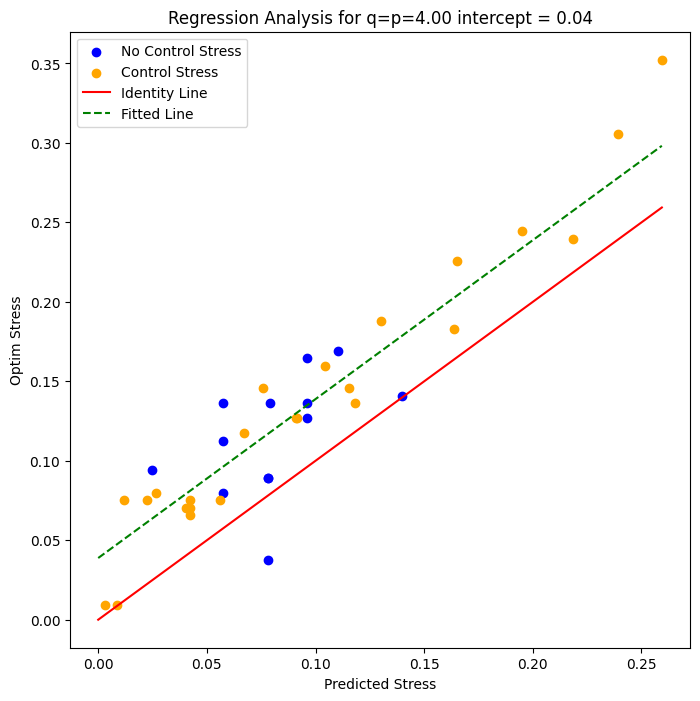

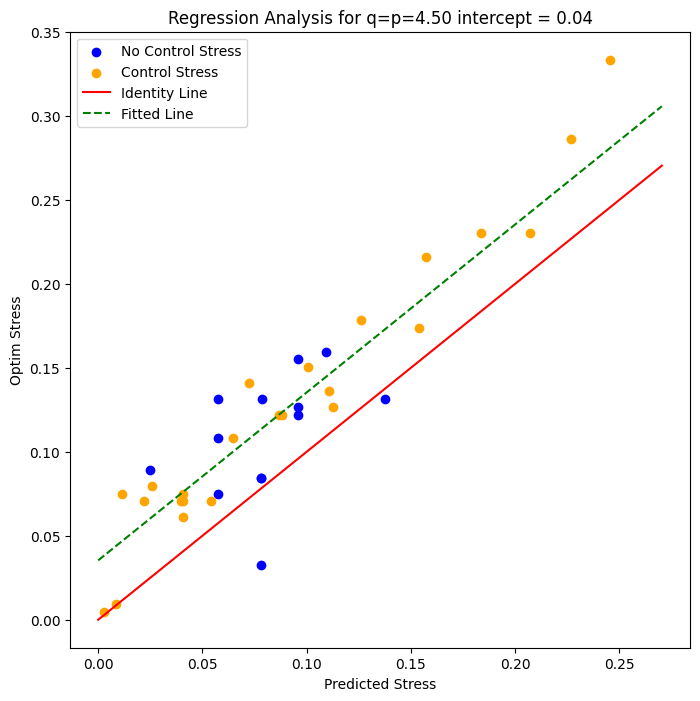

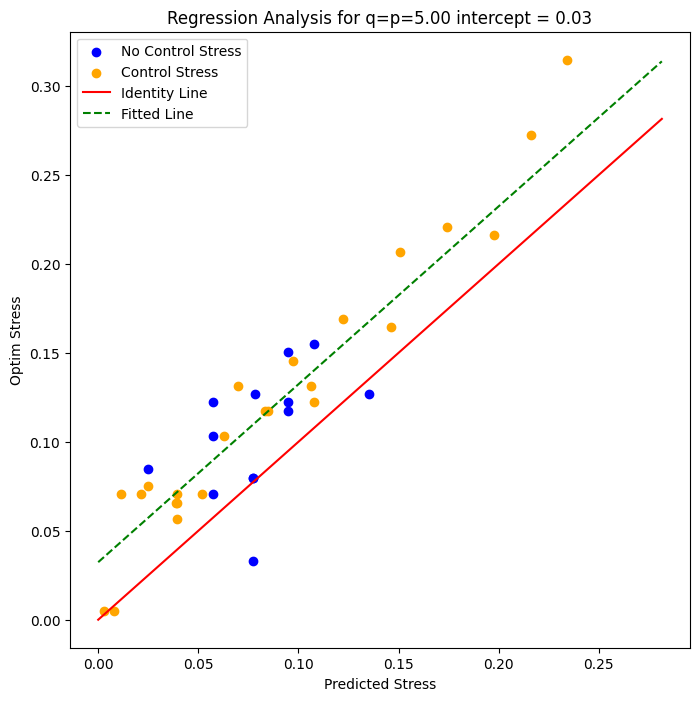

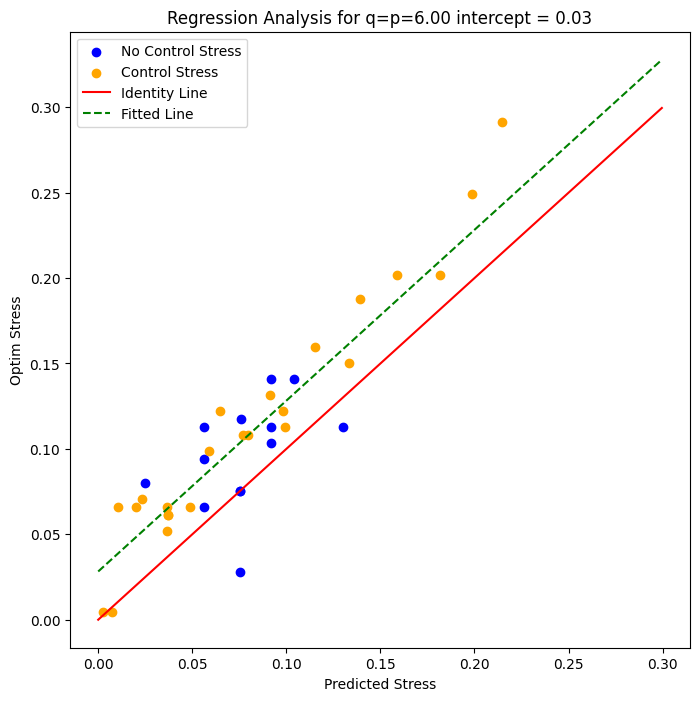

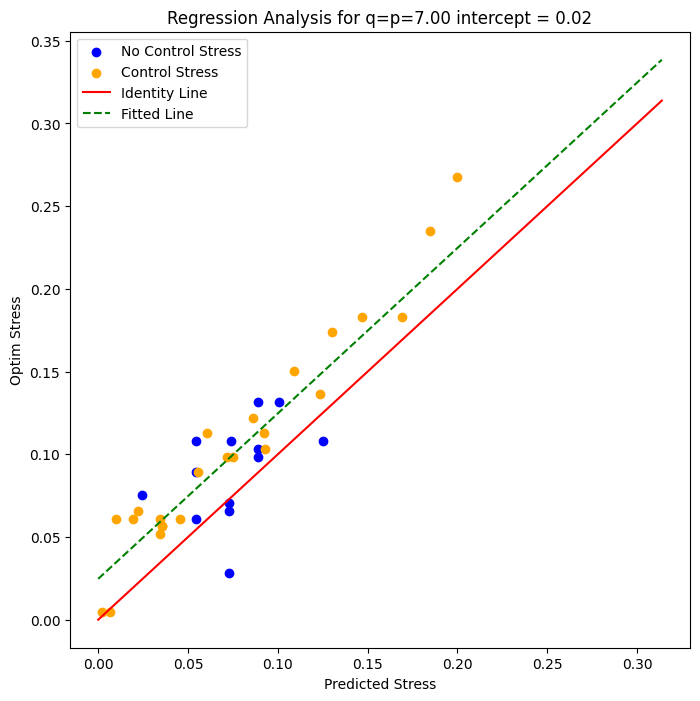

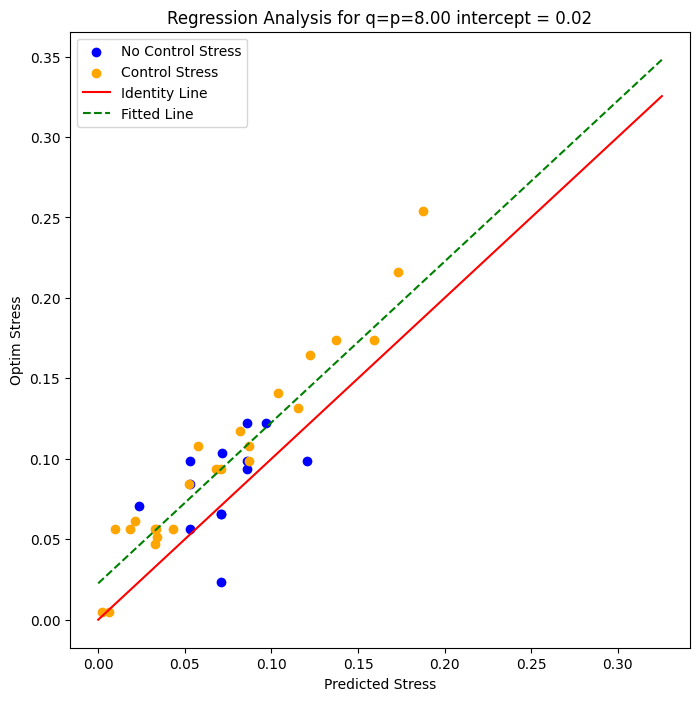

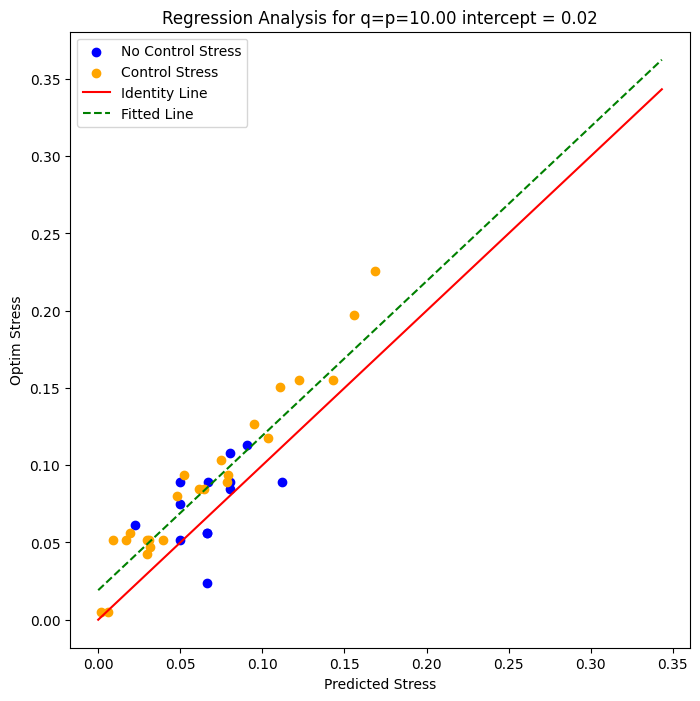

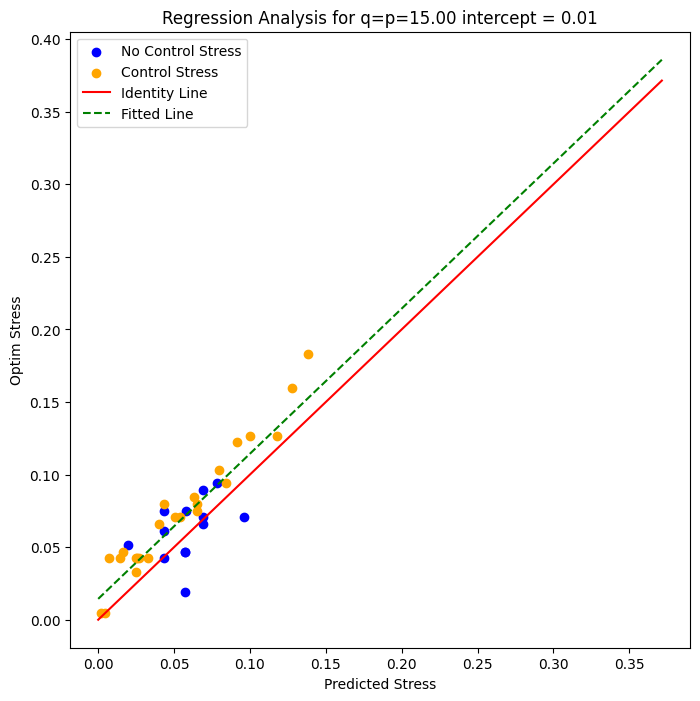

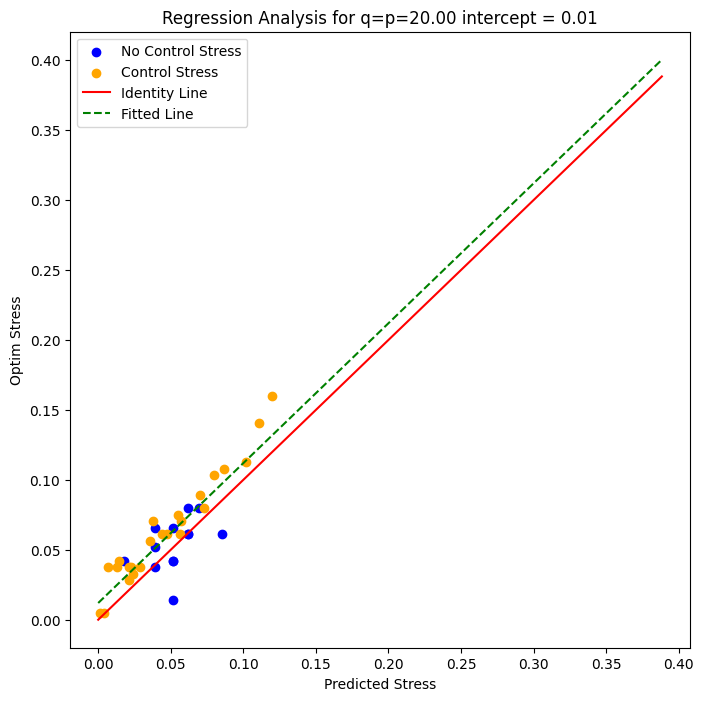

In [79]:
for p, df in sorted(res.items(), key=lambda x: x[0]):
    plot(p, df)

/tmp/ipykernel_39183/1554819858.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


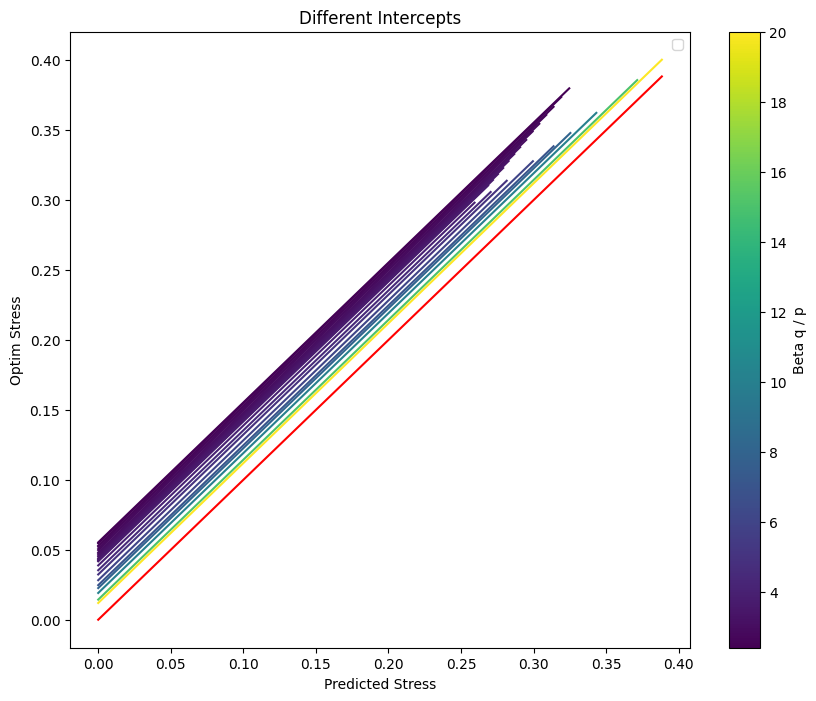

In [80]:
import matplotlib.cm as cm
import matplotlib

color_map = matplotlib.colormaps.get_cmap("viridis")  # Get a gradient color map
p_min, p_max = min(res.keys()), max(res.keys())  # Define the range of p values

plt.figure(figsize=(10, 8))
scalars = np.array([])

for p, df in sorted(res.items(), key=lambda x: x[0]):
    param = p

    mask = df.d_main == 1
    padding = df.loc[mask].copy()
    padding.d_main = 0.995  # Adjust the main value slightly

    # Calculate predictions for the adjusted and original data
    padding_pred = survival_to_stress(
        padding.d_stress, q=param, p=param
    ) - survival_to_stress(padding.d_main, q=param, p=param)
    padding["pred"] = padding_pred

    original_pred = survival_to_stress(
        df.d_stress, p=param, q=param
    ) - survival_to_stress(df.d_main, p=param, q=param)
    df["pred"] = original_pred

    x = np.linspace(0, df["pred"].max(), 30)
    # Fit and plot the regression line
    combined_x = np.concatenate((padding["pred"], df.loc[~mask, "pred"]))
    combined_y = np.concatenate((padding["best"], df.loc[~mask, "best"]))
    intercept = fit_intercept_only(combined_x, combined_y)
    normalized_p = (param - p_min) / (
        p_max - p_min
    )  # Normalize p value for color mapping
    color = color_map(normalized_p)  # Get the color from the color map

    plt.plot(x, regression_line(x, intercept), color=color)

plt.plot(x, x, c="red")
scalars = np.append(scalars, param)

# Add a colorbar to the plot
sm = cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=p_min, vmax=p_max))
sm.set_array(scalars)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label("Beta q / p")
plt.legend()
plt.title(f"Different Intercepts")
plt.xlabel("Predicted Stress")
plt.ylabel("Optim Stress")
plt.show()